# Regression logistique

In [1]:
# Installation et chargement des requirements
%pip install -r requirements.txt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, 
                             confusion_matrix, classification_report, f1_score)

Note: you may need to restart the kernel to use updated packages.


# 1. CHARGEMENT ET PRÉPARATION 
Mise en cohérence avec le modèle NN

In [3]:
# Lecture du fichier
df = pd.read_csv("all_expenses_profil.csv")

# Définition cible et features
y = df["profil"]
X = df.drop(["TOTEXP23", "profil", "DUPERSID", "cum_cost_share"], axis=1, errors="ignore")

# Split Train/Test (Même graine 42 pour comparaison honnête avec le NN)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=42
)

n_samples, n_features = X_train.shape
print(f"Train set: {n_samples} individus. Test set: {X_test.shape[0]} individus.")

# Note : Pour une régression logistique sur des dépenses de santé (souvent des outliers),
# RobustScaler est souvent meilleur que StandardScaler.

num_vars = X.select_dtypes(include=["int64", "float64"]).columns
cat_vars = X.select_dtypes(include=["object", "category"]).columns

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
    ("scaler", RobustScaler()) # RobustScaler gère mieux les valeurs extrêmes de dépenses
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preproc = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_vars),
        ("cat", categorical_transformer, cat_vars)
    ]
)

Train set: 5698 individus. Test set: 1900 individus.


# 2. MODÉLISATION ET GRID SEARCH

In [5]:
# Pipeline complet
pipe_logreg = Pipeline([
    ('preprocess', preproc),
    ('logreg', LogisticRegression(max_iter=5000, random_state=42, solver='lbfgs'))
])

# Grille d'hyperparamètres
# On teste le paramètre C (régularisation)
# ET SURTOUT class_weight (pour voir si le modèle gère mieux le déséquilibre automatiquement)
parameters_logreg = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],
    'logreg__class_weight': [None, 'balanced'] # Test crucial vu nos résultats précédents
}

print("\n--- Démarrage du Grid Search (Optimisation) ---")
clf_logreg = GridSearchCV(
    estimator=pipe_logreg,
    param_grid=parameters_logreg,
    cv=5,
    scoring="f1_macro", # On optimise directement le Macro F1 car c'est notre priorité
    n_jobs=-1,
    verbose=1
)

clf_logreg.fit(X_train, y_train)



--- Démarrage du Grid Search (Optimisation) ---
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/opt/python/lib/python3.13/site-packages/sklearn/impute/_base.py:590: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/opt/python/lib/python3.13/site-packages/sklearn/impute/_base.py:590: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/opt/python/lib/python3.13/site-packages/sklearn/impute/_base.py:590: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/opt/python/lib/python3.13/site-packages/sklearn/impute/_base.py:590: FutureWarning: 

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'logreg__C': [0.01, 0.1, ...], 'logreg__class_weight': [None, 'balanced']}"
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


## 3. RESULTATS


=== Résultats de la Régression Logistique ===
Meilleurs paramètres : {'logreg__C': np.float64(0.00390625)}
Meilleur score CV (F1 Macro) : 0.3297

--- Performances sur le Test Set ---
Accuracy : 0.4621
Macro F1-Score : 0.2637

=== Classification Report ===
              precision    recall  f1-score   support

      Faible       0.80      0.52      0.63      1519
       Moyen       0.00      0.00      0.00       209
       Élevé       0.09      0.50      0.16       172

    accuracy                           0.46      1900
   macro avg       0.30      0.34      0.26      1900
weighted avg       0.65      0.46      0.52      1900



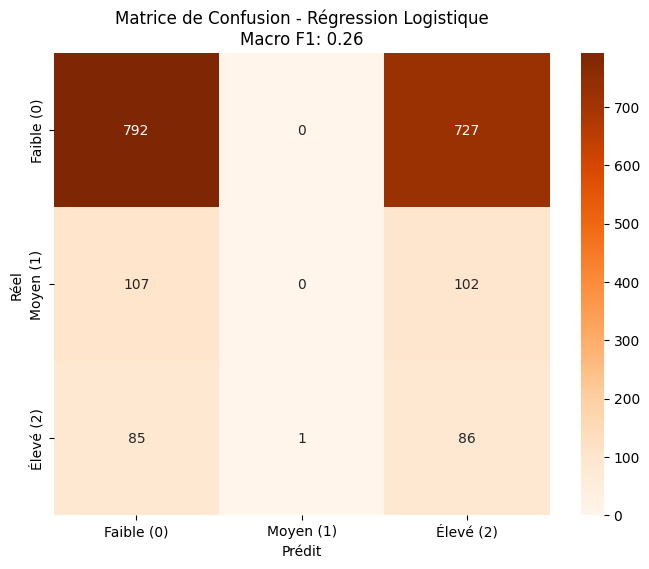

In [9]:
print("\n=== Résultats de la Régression Logistique ===")
print(f"Meilleurs paramètres : {clf_logreg.best_params_}")
print(f"Meilleur score CV (F1 Macro) : {clf_logreg.best_score_:.4f}")

# Prédictions sur le jeu de test
y_pred = clf_logreg.predict(X_test)

# Métriques détaillées
acc = accuracy_score(y_test, y_pred)
macro_f1_logreg = f1_score(y_test, y_pred, average="macro")

print("\n--- Performances sur le Test Set ---")
print(f"Accuracy : {acc:.4f}")
print(f"Macro F1-Score : {macro_f1_logreg:.4f}")

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=['Faible', 'Moyen', 'Élevé']))

# ---------------------------------------------------------------------------
# 5. VISUALISATION
# ---------------------------------------------------------------------------

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['Faible (0)', 'Moyen (1)', 'Élevé (2)'],
            yticklabels=['Faible (0)', 'Moyen (1)', 'Élevé (2)'])
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title(f'Matrice de Confusion - Régression Logistique\nMacro F1: {macro_f1_logreg:.2f}')
plt.show()